## Import libraries

In [15]:
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

pd.set_option('max_columns',None)
import warnings
warnings.filterwarnings('ignore')

## Import data
Data gathered from the CDC and the US Census for a single week during the up-swing of the COVID-19 (Spring 2020)

In [27]:
df = pd.read_csv('covid_clustering_data.csv')
df.head()

,state,county,inf_rate,mrt_rate,Density_per_square_mile_of_land_area_Population,Perct_Total_age0to17,Perct_Total_age18to64,Perct_Total_age65plus,Perct_Total_age85plus,ICU_Beds
0,Alabama,Autauga,0.00,0.0,91.8,23.674035,60.763296,15.562670,1.566519,6
1,Alabama,Baldwin,2.38,8.0,114.6,21.607911,57.948739,20.443350,1.974113,51
2,Alabama,Barbour,0.00,0.0,31.0,20.867328,59.712230,19.420441,1.897030,5
3,Alabama,Bibb,0.00,0.0,36.8,20.477679,63.049107,16.473214,1.620536,0
4,Alabama,Blount,0.00,0.0,88.9,23.153527,58.609959,18.236515,1.784232,6


## Data preparation
Select features to cluster on. It's best to start small and add interesting features iteratively.

In [3]:
df2 = df[[
#  'state',
#  'county',
 'inf_rate',
 'mrt_rate',
#  'Density_per_square_mile_of_land_area_Population',
#  'Perct_Total_age0to17',
#  'Perct_Total_age18to64',
#  'Perct_Total_age65plus',
#  'Perct_Total_age85plus',
#  'ICU_Beds'
    ]]

# Unscaled data can throw off clustering algorithms quite a bit
scaler = MinMaxScaler()
df2_scaled = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

### Optimizing k - number of clusters

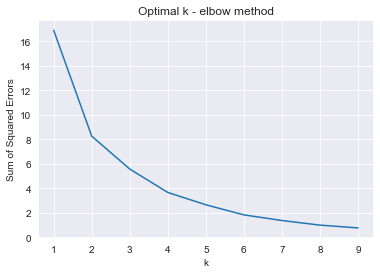

In [4]:
## Optimal k - elbow method
data = df2_scaled.copy()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("k")
plt.ylabel("Sum of Squared Errors")
plt.title('Optimal k - elbow method')
plt.show()

The elbow method is more of a heuristic method, and in this case it's not easy to determine which is best. Ideally, the elbow method produces a more clear "L" shape and is easy to decipher. To get a more mathematically correct answer, I'll use the silhouette score method.

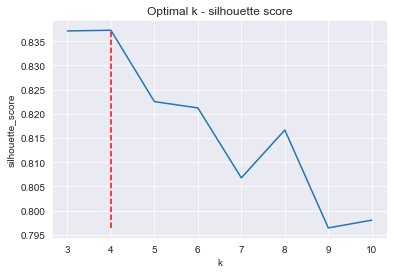

,k,sil_coef
0,3.0,0.837135
1,4.0,0.837281
2,5.0,0.822524
3,6.0,0.821220
4,7.0,0.806752
5,8.0,0.816648
6,9.0,0.796400
7,10.0,0.798007


In [28]:
## Optimal k = max silhouette score
ss = {}
ss_df = pd.DataFrame()

for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df2_scaled)
    label = kmeans.labels_
    ss[k] = silhouette_score(df2_scaled, label, metric='euclidean')
    ss_df = ss_df.append({'k':k,'sil_coef':ss[k]}, ignore_index=True)

plt.figure()
plt.plot(list(ss.keys()), list(ss.values()))
plt.xlabel("k")
plt.ylabel("silhouette_score")
plt.vlines(ss_df.k[ss_df.sil_coef == ss_df.sil_coef.max()], 
           ymin=ss_df.sil_coef.min(), 
           ymax=ss_df.sil_coef.max(),
           color='red',
           linestyles='dashed')
plt.title('Optimal k - silhouette score')
plt.show()

ss_df

Optimal k = 4. 3 is only fractionally in second place and is worth considering.

### Clustering

Params: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 1000, 'random_state': 0, 'algorithm': 'auto'}
----------------------------------------
Clustering performance...
Inertia: 3.5671073563768134
n_iter: 4
----------------------------------------
Cluster centers: 
    inf_rate  mrt_rate  cluster
0  0.019003  0.103467        0
1  0.028604  0.218905        1
2  0.044215  0.521078        2
3  1.000000  0.100000        3
----------------------------------------


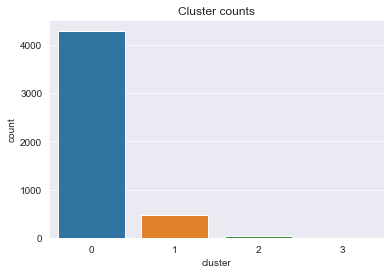

0    4288
1     482
2      34
3       2
Name: cluster, dtype: int64


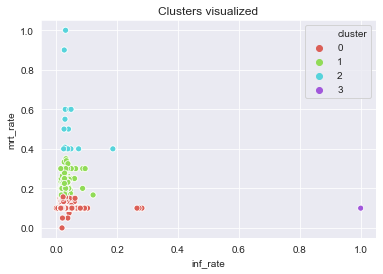

In [6]:
# Hyperparameters
params = {
    'n_clusters':4, # optimal k according to the silhouette score
    'init':'k-means++',
    'n_init':10,
    'max_iter':1000,
    'random_state':0,
    'algorithm':'auto'
}

# Clustering
km = KMeans(**params)

clusters = km.fit_predict(df2_scaled)
print('Params:',params)
print('-'*40)
print('Clustering performance...')
print('Inertia:',km.inertia_)
print('n_iter:',km.n_iter_)
print('-'*40)

#  Cluster centers are the values the algorithm bases each cluster on
centers = pd.DataFrame(km.cluster_centers_)
centers.columns = df2.columns
centers['cluster'] = centers.index

print('Cluster centers: \n',centers)
print('-'*40)

# Append newly created clusters to original DF
clustersDF = pd.DataFrame({'cluster':clusters})
df3 = df2_scaled.merge(clustersDF, how='left', left_index=True, right_index=True)

## Inspect clustering results

# cluster counts
plt.figure()
sns.countplot(df3.cluster)
plt.title('Cluster counts')
plt.show()

print(df3.cluster.value_counts())

# cluster scatter plot #### manual code based on what features are being clustered ####
plt.figure()
sns.scatterplot(df3.inf_rate, df3.mrt_rate, 
                hue=df3.cluster, 
                palette=sns.color_palette("hls", km.n_clusters)
               )
plt.title('Clusters visualized')
plt.show()

### Cluster analysis

#### Cluster centers
Use the cluster centers as a general measure of cluster location and to help interpret each cluster. Each center can be seen as representing the "average observation" within a cluster across all the variables in the analysis.

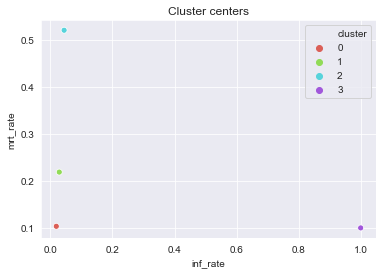

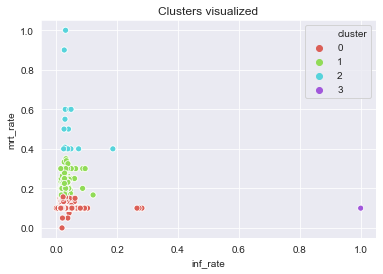

,inf_rate,mrt_rate,cluster
0,0.019003,0.103467,0
1,0.028604,0.218905,1
2,0.044215,0.521078,2
3,1.000000,0.100000,3


In [7]:
sns.scatterplot(centers.inf_rate, centers.mrt_rate, 
                hue=centers.cluster,
                palette=sns.color_palette("hls", km.n_clusters))
plt.title('Cluster centers')
plt.show()

sns.scatterplot(df3.inf_rate, df3.mrt_rate, 
                hue=df3.cluster, 
                palette=sns.color_palette("hls", km.n_clusters)
               )
plt.title('Clusters visualized')
plt.show()

centers 

The clusters appear to represent:
0. Regular infection rates with lower mortality rates (red)
1. Regular infection rates with higher mortality rates (green)
2. High mortality rates (blue)
3. High infection rates (purple)

The outliers are interesting. The highest infection rate counties have fairly low mortality rates, and vice-versa, the highest mortality rate counties have fairly low infection rates.

#### Overlaid data

In [8]:
# attach clusters to original dataframe
df4 = pd.concat([df,df3.cluster], axis=1)
df4.head()

,state,county,inf_rate,mrt_rate,Density_per_square_mile_of_land_area_Population,Perct_Total_age0to17,Perct_Total_age18to64,Perct_Total_age65plus,Perct_Total_age85plus,ICU_Beds,cluster
0,Alabama,Autauga,0.00,0.0,91.8,23.674035,60.763296,15.562670,1.566519,6,0
1,Alabama,Baldwin,2.38,8.0,114.6,21.607911,57.948739,20.443350,1.974113,51,1
2,Alabama,Barbour,0.00,0.0,31.0,20.867328,59.712230,19.420441,1.897030,5,0
3,Alabama,Bibb,0.00,0.0,36.8,20.477679,63.049107,16.473214,1.620536,0,0
4,Alabama,Blount,0.00,0.0,88.9,23.153527,58.609959,18.236515,1.784232,6,0


In [26]:
# attach clusters to original dataframe
df4 = pd.concat([df,df3.cluster], axis=1)

# groupby cluster for each feature's mean 
df4.groupby('cluster').agg({
                            'Density_per_square_mile_of_land_area_Population':'mean',
                            'Perct_Total_age0to17':'mean', 
                            'Perct_Total_age18to64':'mean',
                            'Perct_Total_age65plus':'mean', 
                            'Perct_Total_age85plus':'mean', 
                            'ICU_Beds':aggs
                           })

,Density_per_square_mile_of_land_area_Population,Perct_Total_age0to17,Perct_Total_age18to64,Perct_Total_age65plus,Perct_Total_age85plus,ICU_Beds
,mean,mean,mean,mean,mean,mean
cluster,,,,,,
0,129.021409,22.099747,58.895836,19.004417,2.274542,18.335821
1,878.497095,22.079454,61.188074,16.732471,2.085528,100.053942
2,749.617647,21.514976,61.197028,17.287996,2.159967,36.058824
3,164.700000,20.949798,61.307772,17.742430,2.235810,15.000000


__Notes:__
1. Density_per_square_mile_of_land_area_Population seems to be split into high/low density areas by cluster
2. Perct_Total_age0to17 has little variation
3. Perct_Total_age18to64 has little variation
4. Perct_Total_age65plus has little variation
5. Perct_Total_age85plus has little variation
6. ICU_Beds also seems to have some interesting clusters

Density_per_square_mile_of_land_area_Population and ICU_Beds are interesting features and are worth consideration to be fed into K-Means.

### Next steps options
1. Continue to explore cluster analysis adding different features
2. Use as a feature in a machine learning model
3. Utilize for decision support by prioritizing counties by cluster for pandemic mitigation optimization (supplies, personnel, etc)